In [4]:
from torch.utils.data import Dataset
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import numpy as np
import random
import cv2
import os

random.seed(42069)

In [5]:
# Utils
def pepper_noise(img, threshold=0.1):
    h, w, ch = img.shape
    img_lab = rgb2lab(img)
    img_l = img_lab[..., 0].reshape(h, w) / 100 # Normalize the luminosity between 0 and 1
    mask = np.random.rand(h, w)
    threshold = 0.1
    val = np.exp(img_l) / np.exp(img_l).max() + threshold
    out = img.copy()
    out[mask > val, :] = 0
    return out

def gaussian_noise(img, amount=0.2, calibration=0.05):
    h, w, ch = img.shape
    noise = np.random.normal(0, amount, (h, w, ch)) - calibration
    out = img.copy() / 255
    out = out + noise
    out = np.clip(out, 0, 1)
    return out

In [51]:
# A class defining the dataset
class ImageDataset(Dataset):
    def __init__(self, images_folder: list, noise_level: float = -1):
        super().__init__()
        files = os.listdir(images_folder)
        self.image_paths = [images_folder + "/" + file for file in files]
        self.noise_level = noise_level
        
    # Returns the number of samples, it is used for iteration porpuses
    def __len__(self):
        return len(self.image_paths)
    
    # Returns a random sample for training(generally)
    def __getitem__(self, idx):
        # Load RANDOM clean image into memory...
        image_path = self.image_paths[idx]
        clean_image = cv2.imread(image_path)
        # Perform some preprocessing...
        amount = self.noise_level
        if amount < 0:
            amount = random.random()
        # Generate the noisy image...
        noisy_image = gaussian_noise(clean_image, amount = 0.1)
        noisy_image = pepper_noise(noisy_image)
        
        return {
            'x': noisy_image,
            'y': clean_image
        }

# Test

{'x': tensor([[[[0.0000, 0.0000, 0.0000],
           [0.0100, 0.3078, 0.0122],
           [0.1342, 0.0000, 0.1928],
           ...,
           [0.0000, 0.0000, 0.0000],
           [0.1516, 0.1926, 0.2978],
           [0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000],
           [0.2265, 0.1060, 0.2245],
           [0.2262, 0.1404, 0.2138]],
 
          [[0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000],
           ...,
           [0.1426, 0.1485, 0.1273],
           [0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000]],
 
          ...,
 
          [[0.0000, 0.0000, 0.0000],
           [0.2486, 0.1403, 0.2223],
           [0.0000, 0.0000, 0.0000],
           ...,
           [0.1508, 0.4824, 0.3758],
           [0.0000, 0.0000, 0.0000],
           [0.2222, 0.1258, 0.4118]],
 
          [[0.

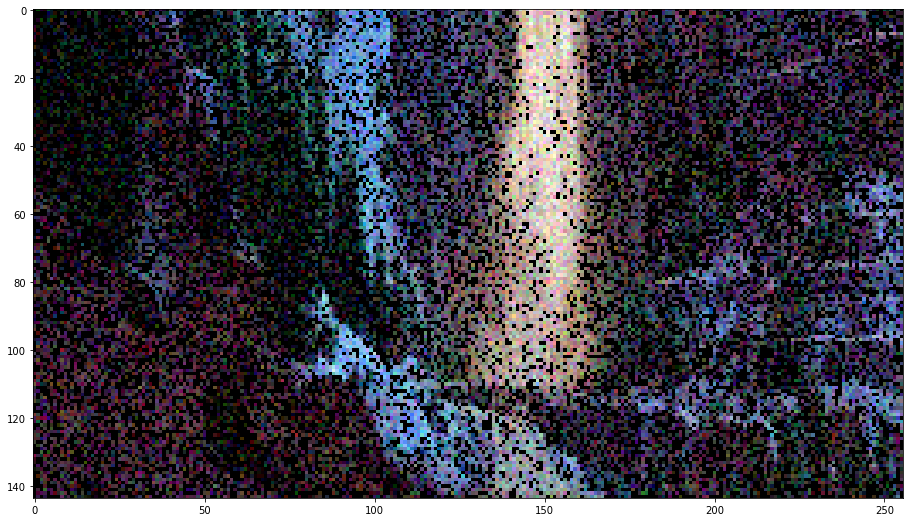

In [52]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

mock_dataset = ImageDataset("data/train")

# for idx in random.shuffle(range(0, len(mock_dataset)))
# plt.imshow(mock_dataset[idx]["x"][0])
mock_loader = DataLoader(mock_dataset, batch_size = 1,shuffle = True)
fg = plt.figure(figsize=(16, 9))
for sample in mock_loader:
    pass
    #plt.imshow(sample["x"][0])
plt.imshow(sample["x"][0])

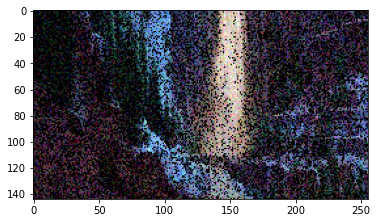